<a href="https://colab.research.google.com/github/UW-CTRL/AA548-spr2024/blob/main/homework/hw2_problem1_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
%matplotlib inline

import jax
import jax.numpy as jnp
import numpy as np
from jax.typing import ArrayLike
import matplotlib.pyplot as plt
import cvxpy as cp

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
#testing git

## Problem 1

In [41]:
# Here is a class describing a dynamically extended unicycle model.
# It will be useful to test code in this problem
# It will be used to test your code in the later problems.

class DynamicallyExtendedUnicycle:

    def __call__(self, state, control):
        return self.drift_dynamics(state) + self.control_matrix(state) @ control

    def drift_dynamics(self, state: ArrayLike) -> tuple:
        '''
        The "drift" term which is the nonlinear term that does not depend on control
        Takes state as an input
        '''
        _, _, theta, v = state
        return jnp.array([v * jnp.cos(theta),
                        v * jnp.sin(theta),
                        0.,
                        0.])

    def control_matrix(self, state: ArrayLike):
        '''
        The control matrix B(x) assuming a control affine system.
        In general, it may be state depedent, thus takes state as an input
        Here, we scaled the control input so we have omega and acceleration between [-1, 1]
        '''
        return jnp.array([[0, 0.],
                          [0, 0.],
                          [jnp.pi/2, 0.],
                          [0., 3.]])


dynamics = DynamicallyExtendedUnicycle()

In [42]:
def barrier_function(state, r=1):
    x, y, theta, v = state
    return x**2 + y**2 - r**2


def control_lyapunov_function_1(state, goal=[3.5,0]):
    x, y, _, _ = state
    xg, yg = goal
    return (x - xg)**2 + (y - yg)**2

def control_lyapunov_function_2(state, goal=[3.5,0]):
    x, y, theta, _ = state
    xg, yg = goal
    return (theta - jnp.arctan2(yg - y, xg - x))**2

### 1(b)(i)

In [43]:


def lie_derivative(func, vector_field_func, state):
    '''
    func: a function that takes in a state and returns a scalar value.
          i.e., func(state) = scalar
    vector_field_func: a function that takes in a state and returns a
                      vector/matrix. i.e., func(state) = vector/matrix
    state: an array describing the state which is the input to func and
          vector_field_func
    '''
    
    ## put your code here##
    s = jax.jacobian(func)(state)
    f = vector_field_func(state)
    Lied = s @ f
    return Lied
    #######################



### Fill this for 1(b)

In [44]:
def control_constraint_degree_1(h, dynamics, state, alpha_func):
    '''
    h: a function that takes in a state and returns a scalar value.
          i.e., h(state) = scalar
    dynamics: the DynamicallyExtendedUnicycle class defined above
    state: an array describing the state which is the input to func and
          vector_field_func
    alpha_func: the class K function

    Compute the coefficients for the CBF/CLF inequality terms, assuming all the terms are moved to the LHS

    Lfh(z) + Lgh(z)u + alpha(h(z))

    Returns:
    Lfh
    Lgh
    bound (=alpha(h(z)))
    Note: This function should work regardless of whether you are computer for CLF or CBF.
    '''
    ## put your code here##
    f = dynamics.drift_dynamics
    g = dynamics.control_matrix

    a1 = alpha_func

    Lfh = lie_derivative(h, f, state)
    Lgh = lie_derivative(h, g, state)
    bound = a1(h(state))

    return Lfh, Lgh, bound
    #######################


def control_constraint_degree_2(h, dynamics, state, class_K_funcs):
    '''
    h: a function that takes in a state and returns a scalar value.
          i.e., h(state) = scalar
    dynamics: the DynamicallyExtendedUnicycle class defined above
    state: an array describing the state which is the input to func and
          vector_field_func
    class_K_funcs: a 2-list of class K function [alpha_func_1, alpha_func_2]

    Compute the coefficients for the CBF/CLF inequality terms, assuming all the terms are moved to the LHS

    Lf2h(z) + LgLfh(z)u + Lfa1h(z) + a2_term

    Returns:
    Lf2h
    LgLfh
    Lfa1h
    a2_term
    '''
    ## put your code here##
    f = dynamics.drift_dynamics
    g = dynamics.control_matrix

    a1 = class_K_funcs[0]
    a2 = class_K_funcs[1]

    Lfh = lie_derivative(h, f, state)
    Lfhf = lambda z : lie_derivative(h, f, z)
    L2fh = lie_derivative(Lfhf, f, state)
    LgLfh = lie_derivative(Lfhf, g, state)
    #conv = lambda z : jnp.convolve(f(z), a1(z), mode='same')
    conv = lambda z :  a1(f(z))
    Lfa1h = lie_derivative(h, conv, state)
    a2_term = a2(Lfh+a1(h(state)))

    return L2fh, LgLfh, Lfa1h, a2_term

    #######################

In [45]:
alpha1 = lambda x: 2 * x
alpha2 = lambda x: 2 * x
test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])


L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, test_state, [alpha1, alpha2])
print("Relative degree 2")
print("L2fb: %.2f"%L2fb)
print("LgLfb: [%.2f, %.2f]"%(LgLfb[0], LgLfb[1]))
print("Lfa1b: %.2f"%Lfa1b)
print("a2_term: %.2f\n"%(a2_term))

Relative degree 2
L2fb: 2.00
LgLfb: [6.57, -4.77]
Lfa1b: -3.18
a2_term: 12.82



### 1(b)(ii) -- run this to print out values

In [46]:
alpha1 = lambda x: 2 * x
alpha2 = lambda x: 2 * x
test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])


L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, test_state, [alpha1, alpha2])
print("Relative degree 2")
print("L2fb: %.2f"%L2fb)
print("LgLfb: [%.2f, %.2f]"%(LgLfb[0], LgLfb[1]))
print("Lfa1b: %.2f"%Lfa1b)
print("a2_term: %.2f\n"%(a2_term))

# since the CBF is relative degree two, Lgb should be zero
Lfb, Lgb, bound = control_constraint_degree_1(barrier_function, dynamics, test_state, alpha1)
print("Relative degree 1")
print("Lfb: %.2f"%Lfb)
print("Lgb: [%.2f, %.2f]"%(Lgb[0], Lgb[1]))
print("bound: %.2f\n"%(bound))


Relative degree 2
L2fb: 2.00
LgLfb: [6.57, -4.77]
Lfa1b: -3.18
a2_term: 12.82

Relative degree 1
Lfb: -1.59
Lgb: [0.00, 0.00]
bound: 8.00



### 1(b)(iii) -- run this to print out values

In [47]:
beta1 = lambda x: 0.5 * x
beta2 = lambda x: 0.5 * x
test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])


L2fV1, LgLfV1, Lfb1V1, b2_term = control_constraint_degree_2(control_lyapunov_function_1, dynamics, test_state, [beta1, beta2])
print("Relative degree 2")
print("L2fV1: %.2f"%L2fV1)
print("LgLfV1: [%.2f, %.2f]"%(LgLfV1[0], LgLfV1[1]))
print("Lfb1V1: %.2f"%Lfb1V1)
print("b2_term: %.2f\n"%(b2_term))


# sanity check
# since the CLF V1 is relative degree two, LgV1 should be zero
LfV1, LgV1, bound = control_constraint_degree_1(control_lyapunov_function_1, dynamics, test_state, beta1)
print("Relative degree 1")
print("LfV1: %.2f"%LfV1)
print("LgV1: [%.2f, %.2f]"%(LgV1[0], LgV1[1]))
print("bound: %.2f\n"%(bound))


Relative degree 2
L2fV1: 2.00
LgLfV1: [7.66, -25.67]
Lfb1V1: -4.28
b2_term: 1.78

Relative degree 1
LfV1: -8.56
LgV1: [0.00, 0.00]
bound: 12.12



### 1(b)(iv) -- run this to print out values

In [48]:
# since the CLF V2 is relative degree one, LgV2 should be non-zero
test_state = jnp.array([-1.0, 2.0, 0.1, 1.0])

LfV2, LgV2, bound = control_constraint_degree_1(control_lyapunov_function_2, dynamics, test_state, beta1)
print("Relative degree 1")
print("LfV2: %.2f"%LfV2)
print("LgV2: [%.2f, %.2f]"%(LgV2[0], LgV2[1]))
print("bound: %.2f\n"%(bound))


Relative degree 1
LfV2: 0.10
LgV2: [1.63, 0.00]
bound: 0.13



### 1(c) -- set up the optimization problem here

In [49]:
m = 2
gamma1 = 0.05
gamma2 = 10

# use Parameter so the values can updated during the simulation loop as opposed to redefining a new problem each time step
u = cp.Variable(m)
epsilon = cp.Variable(m)
dV1 = cp.Parameter(m)
dV2 = cp.Parameter(m)
db = cp.Parameter(m)
V1 = cp.Parameter(1)
V2 = cp.Parameter(1)
b = cp.Parameter(1)


#### put your code here ####
# objective = ...
# constraints = ...
objective = cp.Minimize(u[1]**2 + gamma1*(u[0]**2) + gamma2*((epsilon[0]**2+epsilon[1]**2)))
constraints = [b + db @ u >= 0,V1 + dV1 @ u <= epsilon[0], V2 + dV2 @ u <= epsilon[1], epsilon[0] >=0, epsilon[1] >=0]
######

prob = cp.Problem(objective, constraints)


### Run the following cells to simulate and plot results
This uses your control_constraint_degree_1, control_constraint_degree_2, and cxvpy code defined above

In [50]:
dt = 0.1
T_max = 200

state0 = jnp.array([-3., 1., -np.pi/6, 0.5])
states = [state0]
controls = []

for t in range(T_max):
    state = states[t]

    # V1 CLF constraint
    L2fV1, LgLfV1, Lfb1V1, b2_term = control_constraint_degree_2(control_lyapunov_function_1, dynamics, state, [beta1, beta2])
    dV1.project_and_assign(LgLfV1)
    V1.project_and_assign(L2fV1 + Lfb1V1 + b2_term)

    # V2 CLF constraint
    LfV2, LgV2, bound = control_constraint_degree_1(control_lyapunov_function_2, dynamics, state, beta1)
    dV2.project_and_assign(LgV2)
    V2.project_and_assign(LfV2 + bound)

    # b CBF constraint
    L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, state, [alpha1, alpha2])
    db.project_and_assign(LgLfb)
    b.project_and_assign(L2fb + Lfa1b + a2_term)

    clf_value = control_lyapunov_function_1(state).item()
    if (clf_value < 1E-2) or state[0] > 3:
        print("reached goal!!")
        break
    prob.solve()

    states.append(state + dynamics(state, u.value) * dt)
    controls.append(u.value)
states = jnp.stack(states)
controls = jnp.stack(controls)


reached goal!!


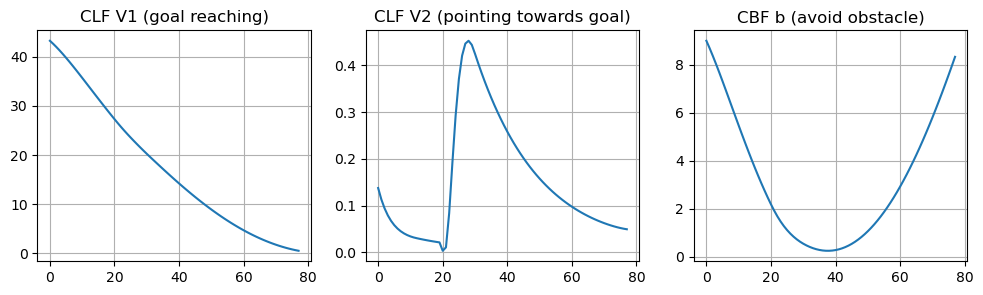

In [51]:
# CLF/CBF values over the trajectory
clf_V1_values = jax.vmap(control_lyapunov_function_1, [0])(states)
clf_V2_values = jax.vmap(control_lyapunov_function_2, [0])(states)
cbf_b_values = jax.vmap(barrier_function, [0])(states)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(clf_V1_values)
plt.title("CLF V1 (goal reaching)")
plt.grid()

plt.subplot(1,3,2)
plt.plot(clf_V2_values)
plt.title("CLF V2 (pointing towards goal)")
plt.grid()

plt.subplot(1,3,3)
plt.plot(cbf_b_values)
plt.title("CBF b (avoid obstacle)")
plt.grid()

### Plotting functions

In [52]:
# plotting set up
lim_value = 4
grid_points_N = 101
grid_points = jnp.linspace(-lim_value, lim_value, grid_points_N)
theta_points = jnp.linspace(-jnp.pi, jnp.pi, grid_points_N)
X, Y, THETA = jnp.meshgrid(grid_points, grid_points, theta_points)
batched_states = jnp.concatenate([X.reshape(-1,1), Y.reshape(-1,1), THETA.reshape(-1,1), THETA.reshape(-1,1) ], 1)
clf_V1_values_grid = jax.vmap(control_lyapunov_function_1, [0])(batched_states)
clf_V2_values_grid = jax.vmap(control_lyapunov_function_2, [0])(batched_states)

X, Y = jnp.meshgrid(grid_points, grid_points)
batched_states = jnp.concatenate([X.reshape(-1,1), Y.reshape(-1,1), X.reshape(-1,1), X.reshape(-1,1) ], 1)
cbf_values_grid = jax.vmap(barrier_function, [0])(batched_states)

xmin = -3
xmax = 3
ymin = -3
ymax = 3


In [53]:

def rotate_vector_ccw(vector, theta):
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)],
                     [jnp.sin(theta), jnp.cos(theta)]]) @ vector

def plot_car(ax, state, car_length=0.5, car_width=0.3, color='lightskyblue', alpha=0.6):
    pos = state[:2]
    theta = state[2]
    left_corner = pos + rotate_vector_ccw(0.5 * jnp.array([-car_length, -car_width]), theta)
    car = Rectangle(left_corner, car_length, car_width, angle=theta * 180 / jnp.pi, color=color, alpha=alpha)
    ax.add_patch(car)
    v_vector = jnp.stack([pos, pos + 3 * car_length / 4 * jnp.array([np.cos(theta), np.sin(theta)])])
    ax.plot(v_vector[:,0], v_vector[:,1])
    return ax

def plot_halfspace_lessthan(ax, a, b, c, xmin, xmax, ymin, ymax, color, alpha):
    if b == 0:
        if c == 0:
            if a < 0:
                ax.fill([-c/a, xmax, xmax, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
            else:
                ax.fill([-c/a, xmin, xmin, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
        else:
            if a < 0:
                ax.fill([-c/a, xmax, xmax, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
            else:
                ax.fill([-c/a, xmin, xmin, -c/a], [ymin, ymin, ymax, ymax], color=color, alpha=alpha)
    else:
        y1 = -(a * xmin + c ) / b
        y2 = -(a * xmax + c ) / b
        if b > 0:
            plt.fill_between([xmin, xmax], [y1, y2], [ymin, ymin], color=color, alpha=alpha)
        else:
            plt.fill_between([xmin, xmax], [ymax, ymax], [y1, y2], color=color, alpha=alpha)

    return ax

def plot_halfspace_greaterthan(ax, a, b, c, xmin, xmax, ymin, ymax, color, alpha):
    return plot_halfspace_lessthan(ax, -a, -b, -c, xmin, xmax, ymin, ymax, color, alpha)




In [54]:
def goo(t):
    state = states[t]
    control = controls[t]
    x, y, theta, v = state
    omega, a = control
    fig, axs = plt.subplots(1, 3, figsize=(16,4))
    ax = axs[0]
    ax.plot(states[:t,0], states[:t,1], linestyle='--', color='black', zorder=5)
    ax.contourf(X[:,:], Y[:,:], cbf_values_grid.reshape(grid_points_N, grid_points_N), 20, alpha=0.6, cmap="gist_gray")
    ax.contour(X[:,:], Y[:,:], cbf_values_grid.reshape(grid_points_N, grid_points_N), [0,.01], alpha=0.6, colors="black")

    plot_car(ax, state)
    ax.scatter([x], [y], color="blue", s=10, zorder=5)
    ax.set_title("CBF value = %.2f (blue dot should avoid circle)"%barrier_function(state))
    ax.axis("equal")
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.grid()

    ax = axs[1]
    ax.plot(controls[:t,0], label="omega")
    ax.plot(controls[:t,1], label="accel")
    ax.set_xlim([0., states.shape[0]])
    ax.set_ylim([-1.1, 1.1])
    ax.grid()
    ax.legend()


    ax = axs[2]
    ax.scatter([omega], [a], color="blue", s=50, zorder=5)

    L2fb, LgLfb, Lfa1b, a2_term = control_constraint_degree_2(barrier_function, dynamics, state, [alpha1, alpha2])
    plot_halfspace_lessthan(ax, LgLfb[0], LgLfb[1], L2fb + Lfa1b + a2_term, -1, 1, -1, 1, "lightskyblue", 0.6)

    L2fV1, LgLfV1, Lfb1V1, b2_term = control_constraint_degree_2(control_lyapunov_function_1, dynamics, state, [beta1, beta2])
    plot_halfspace_greaterthan(ax, LgLfV1[0], LgLfV1[1], L2fV1 + Lfb1V1 + b2_term, -1, 1, -1, 1, "salmon", 0.4)

    LfV2, LgV2, bound = control_constraint_degree_1(control_lyapunov_function_2, dynamics, state, beta1)
    plot_halfspace_greaterthan(ax, LgV2[0], LgV2[1], LfV2 + bound, -1, 1, -1, 1, "salmon", 0.4)

    ax.set_title("Control Constraints (white is feasible)")
    ax.set_xlim([-1., 1.])
    ax.set_ylim([-1., 1.])
    ax.grid()
    ax.set_xlabel("\omega")
    ax.set_ylabel("$a$")





### Run this for an interactive widget
but may not be rendered properly in colab, so feel free to not run the following cell.

In [55]:
interact(goo, t=(0,states.shape[0]-1))

interactive(children=(IntSlider(value=38, description='t', max=77), Output()), _dom_classes=('widget-interact'…

<function __main__.goo(t)>

### Include this plot in your write up
Just shows the plot for a selected time step

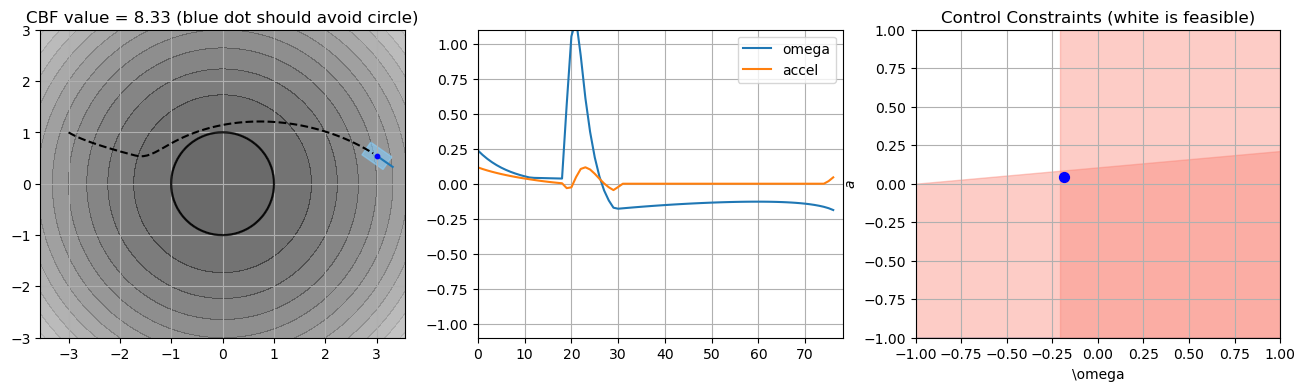

In [56]:
goo(states.shape[0]-1)